In [1]:
import numpy as np
import numpy.typing as npt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# https://scikit-learn.org/stable/modules/cross_validation.html#stratification
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

from math import ceil

from library.kernel_svm import SVM_SGA

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
df = pd.read_csv("dataset/parkinsons.csv")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
df["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

In [4]:
# up-sampling minority class
df_majority = df[df.status == 1]
df_minority = df[df.status == 0]

df_minority_upsampled = resample(
	df_minority,
	replace=True,
	n_samples=147, # match majority class
	random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled["status"].value_counts()

1    147
0    147
Name: status, dtype: int64

In [5]:
X = df_upsampled.drop(["status", "name"], axis=1)
y = df_upsampled["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, shuffle = True, random_state = 42, stratify=y)

print(X_train.shape, X_test.shape)

(205, 22) (89, 22)


In [6]:
kf = StratifiedKFold(n_splits=5)

scaler = StandardScaler()
pca = PCA(n_components=2)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_pca = pca.fit_transform(X_test)

print("PCA on testing set")
print(f"Percentage of variance explained by the 2 first principal components: {pca.explained_variance_ratio_}")

X_train

PCA on testing set
Percentage of variance explained by the 2 first principal components: [0.60334435 0.11194657]


array([[-0.15303656, -0.12195999, -0.89770942, ..., -0.67503859,
        -0.99597548,  0.04350674],
       [-0.72327754, -0.68724528, -0.12701902, ...,  0.82018476,
        -0.17778325, -0.35198285],
       [ 0.95510001,  0.13600003,  1.47095538, ..., -0.19022299,
         0.59758806, -0.47924986],
       ...,
       [-0.24312035, -0.50844976,  0.15620732, ..., -0.47024569,
         0.02579914, -0.72298436],
       [ 0.75816625,  0.02545012,  1.3332668 , ..., -0.32093256,
        -0.51344065, -1.25756083],
       [ 0.48123809, -0.09517955,  1.04499314, ...,  0.00736013,
         0.24064125, -0.54615647]])

In [7]:
def plot_data(X: npt.NDArray, y: npt.NDArray):
	# project points on the 2 first principal components
	#scaler = StandardScaler()
	#X_scaled = scaler.fit_transform(X)

	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)

	print(pca.explained_variance_ratio_)

	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 0.7
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 0.7
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X_pca[:,0][label_indices], 
			X_pca[:,1][label_indices], 
			c=options[label]["color"], 
			label=options[label]["label"], 
			alpha=options[label]["alpha"]
		)

	x_limits = ceil(max(X_pca[:,0].min() - 1, X_pca[:,0].max() + 1))
	y_limits = ceil(max(X_pca[:,1].min(), X_pca[:,1].max()))

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal Component 1")
	ax.set_ylabel("Principal Component 2")

	plt.show()

In [8]:
def plot_margins(X: npt.NDArray, y: npt.NDArray, support_vectors: npt.NDArray, clf):
	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 1.0
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 1.0
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X[:,0][label_indices], 
			X[:,1][label_indices], 
			c=options[label]["color"],
			s=30,
			label=options[label]["label"]
		)


	# plot support vectors
	ax.scatter(
		support_vectors[:,0], 
		support_vectors[:,1], 
		#c="grey",
		#marker="s",
		s=100,
		linewidth=1,
		facecolors=None,
		edgecolors="k",
		alpha=0.5,
		label="support vectors"
	)

	w = clf.coef_[0]
	b = clf.intercept_[0]
	
	x_limits = ceil(max(X[:,0].min() - 1, X[:,0].max() + 1))
	y_limits = ceil(max(X[:,1].min() - 1, X[:,1].max() + 1))

	xx = np.arange(X[:,0].min() - 1, X[:,0].max() + 1, step=0.1)

	# hyperplane
	a = -w[0] / w[1]
	yy = (a * xx) - (b / w[1])


	# margins
	w_hat = w / np.linalg.norm(w)
	margin = 1 / np.linalg.norm(w)

	hyperplane_points = np.array(list(zip(xx, yy)))
	yy_up = hyperplane_points + w_hat * margin
	yy_down = hyperplane_points - w_hat * margin

	# plot hyperplane
	ax.plot(xx, yy, "k-", label="hyperplane")

	# plot margins
	ax.plot(yy_up[:, 0], yy_up[:, 1], "k--", label="margin")
	ax.plot(yy_down[:, 0], yy_down[:, 1], "k--")

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal component 1")
	ax.set_ylabel("Principal component 2")

	plt.show()

In [9]:
def plot_decision_regions(X: npt.NDArray, y: npt.NDArray, support_vectors: npt.NDArray, clf, cmap: str = "Spectral"):
	fig, ax = plt.subplots(1, figsize = (12, 7))

	options = {
		0: {
			"color": "royalblue",
			"label": "Healty",
			"marker": "o",
			"alpha": 1.0
		},
		1: {
			"color": "orange",
			"label": "Parkinson",
			"marker": "o",
			"alpha": 1.0
		}
	}

	for label in np.unique(y.tolist()):
		label_indices = np.where(y.tolist() == label)[0]

		# plot points (that are not support vectors)
		ax.scatter(
			X[:,0][label_indices], 
			X[:,1][label_indices], 
			#c=options[label]["color"], 
			cmap=cmap,
			s=30,
			label=options[label]["label"]
		)

	# plot support vectors
	ax.scatter(
		support_vectors[:,0], 
		support_vectors[:,1], 
		#c="grey",
		#marker="s",
		s=100,
		linewidth=1,
		facecolors=None,
		edgecolors="k",
		#alpha=0.3,
		label="support vectors"
	)

	# create the meshgrid for the contour decision function
	x_limits = ceil(max(X[:,0].min() - 1, X[:,0].max() + 1))
	y_limits = ceil(max(X[:,1].min() - 1, X[:,1].max() + 1))

	xx, yy = np.meshgrid(
		np.arange(-x_limits, x_limits, step=0.1),
		np.arange(-y_limits, y_limits, step=0.1)
	)

	f = clf.decision_function(np.c_[np.ravel(xx), np.ravel(yy)])
	f = f.reshape(xx.shape)
	ax.contourf(xx, yy, f, alpha = 0.5, cmap=cmap)

	#plot_decision_regions(X, y, clf)

	ax.set_xlim(-x_limits, x_limits)
	ax.set_ylim(-y_limits, y_limits)

	ax.legend(loc="best")
	ax.set_xlabel("Principal component 1")
	ax.set_ylabel("Principal component 2")

	plt.show()

In [10]:
def plot_cm(y_pred, y_true):
	levels = ["Healthy", "Parkinson"]

	fig, ax = plt.subplots(1, figsize = (8, 5))

	cm = confusion_matrix(y_true, y_pred)
	sns.heatmap(pd.DataFrame(cm), ax=ax, annot=True)

	ax.set_xlabel("Predicted")
	ax.set_ylabel("Actual")
	ax.xaxis.set_ticklabels(levels)
	ax.yaxis.set_ticklabels(levels)

[0.60284464 0.12807327]


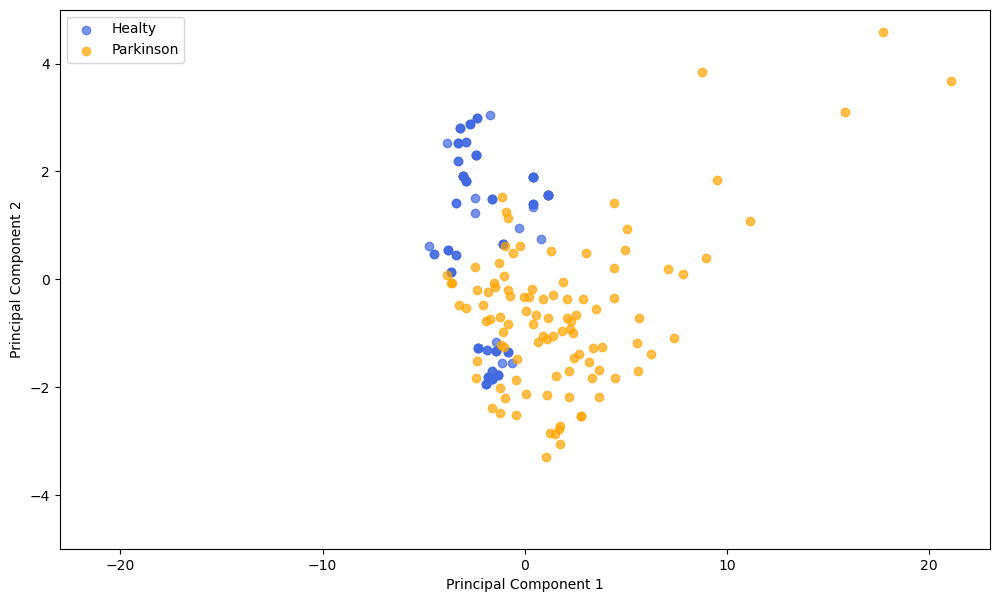

In [11]:
plot_data(X_train, y_train)

[0.60334435 0.11194657]


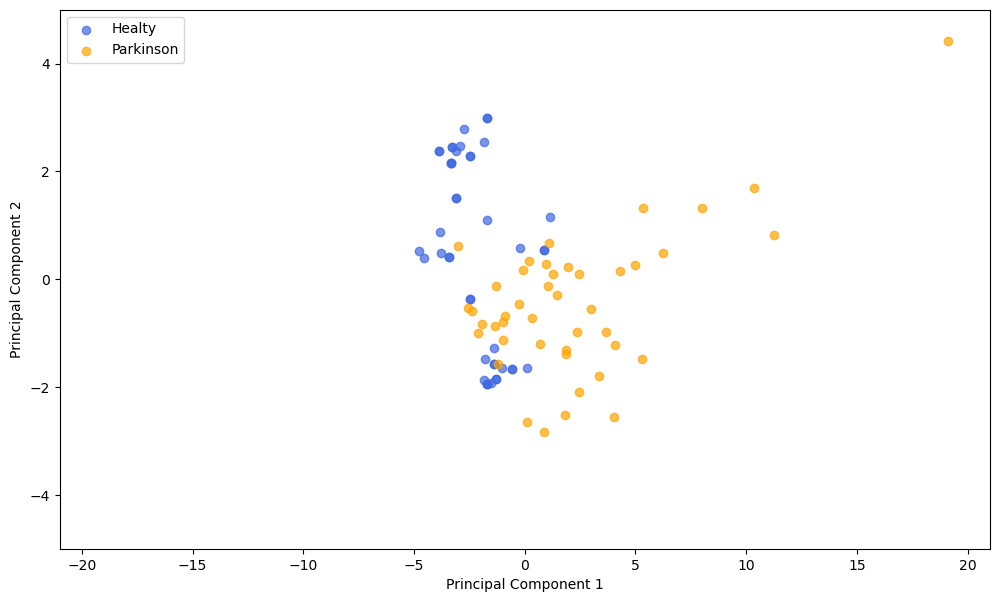

In [12]:
plot_data(X_test, y_test)

## Hard Margin SVM

In [13]:
linear_clf = SVC(kernel="linear", C=0.00001, verbose=True)
linear_clf.fit(X_train, y_train)

test_score = linear_clf.score(X_test, y_test)

print("----- Linear SVM -----")
print(f"score on testing set: {test_score}")
print(f"number of support vectors: {len(linear_clf.support_vectors_)}")

[LibSVM]*
optimization finished, #iter = 102
obj = -0.002032, rho = 0.936332
nSV = 204, nBSV = 204
Total nSV = 204
----- Linear SVM -----
score on testing set: 0.4943820224719101
number of support vectors: 204


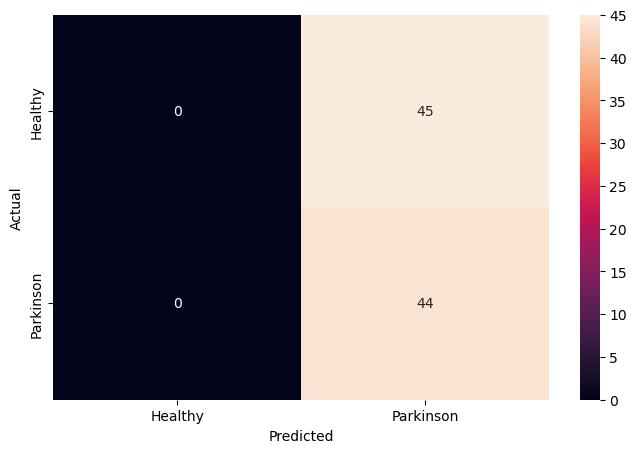

In [14]:
y_pred_sm = linear_clf.predict(X_test)
plot_cm(y_pred=y_pred_sm, y_true=y_test)

[LibSVM]*
optimization finished, #iter = 44
obj = -0.000878, rho = -0.991234
nSV = 88, nBSV = 88
Total nSV = 88


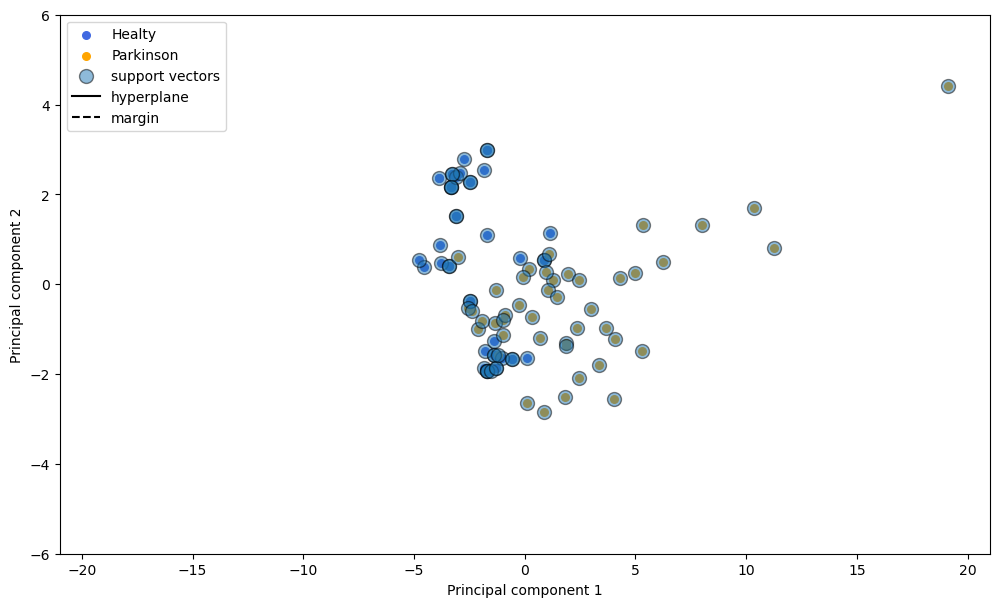

In [15]:
linear_clf.fit(X_test_pca, y_test)
plot_margins(X_test_pca, y_test, linear_clf.support_vectors_, linear_clf)

## Soft Margin SVM

In [16]:
soft_margin_params = {
	"C": [0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0, 2.1, 2.2, 2.25, 2.3, 2.5, 2.7, 3.0]
}

gs_soft = GridSearchCV(
	estimator=SVC(kernel="linear"), 
	param_grid=soft_margin_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_soft.fit(X_train, y_train)
val_score = np.round(gs_soft.best_score_, 3)
test_score = np.round(gs_soft.score(X_test, y_test), 3)

print("----- Linear SVM with C Penalty -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_soft.best_params_}")
print(f"number of support vectors: {len(gs_soft.best_estimator_.support_vectors_)}")

----- Linear SVM with C Penalty -----
score on validation set: 0.854
score on testing set: 0.831
best params: {'C': 2.2}
number of support vectors: 74


In [25]:
SVC(kernel="linear", C=gs_soft.best_params_["C"], verbose=True).fit(X_train, y_train).score(X_train, y_train)

[LibSVM]......*.....*
optimization finished, #iter = 2260
obj = -125.501950, rho = 0.525203
nSV = 74, nBSV = 52
Total nSV = 74


0.9024390243902439

In [26]:
# just to get the min value of the objective function
SVC(kernel="linear", C=gs_soft.best_params_["C"], verbose=True).fit(X_test, y_test)

[LibSVM]....*..........*
optimization finished, #iter = 1285
obj = -53.565617, rho = 0.595083
nSV = 35, nBSV = 21


SVC(C=2.2, kernel='linear', verbose=True)

Total nSV = 35


#### Predictions on testing set

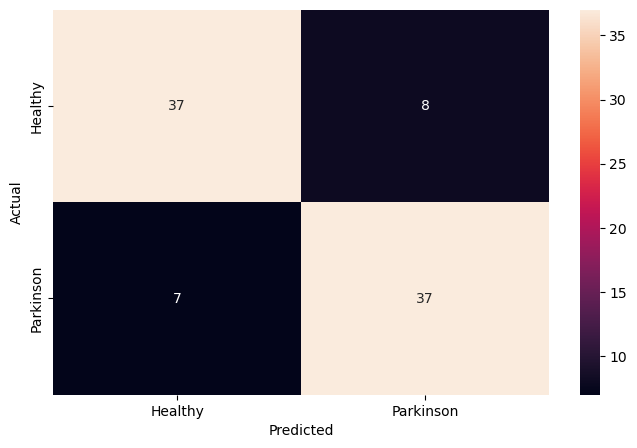

In [18]:
y_pred_hm = gs_soft.predict(X_test)

plot_cm(y_pred=y_pred_hm, y_true=y_test)

#### Plot of the decision region for the 2 principal components

number of support vectors: 35


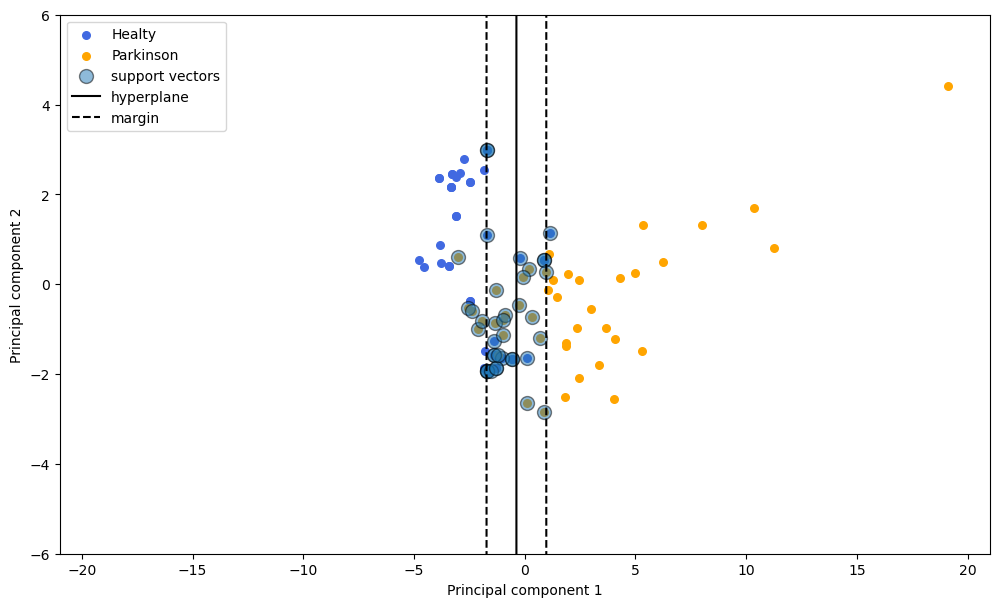

In [19]:
svm_sm = SVC(kernel="linear", C=gs_soft.best_params_["C"])

svm_sm.fit(X_test, y_test)
print(f"number of support vectors: {len(svm_sm.support_vectors_)}")

clf_sm = svm_sm.fit(X_test_pca, y_test)
plot_margins(X_test_pca, y_test, svm_sm.support_vectors_, clf_sm)

## Kernel Trick

In [20]:
kernel_params = {
	"C": np.linspace(0.1, 1.0, 50),
	"gamma": np.linspace(0.1, 0.5, 25)
}

gs_kernel = GridSearchCV(
	estimator=SVC(kernel="rbf"), 
	param_grid=kernel_params,
	cv=kf,
	refit=True,
	return_train_score=True
)

gs_kernel.fit(X_train, y_train)
val_score = np.round(gs_kernel.best_score_, 3)
test_score = np.round(gs_kernel.score(X_test, y_test), 3)

print("----- SVM with Kernel Trick -----")
print(f"score on validation set: {val_score}")
print(f"score on testing set: {test_score}")
print(f"best params: {gs_kernel.best_params_}")

----- SVM with Kernel Trick -----
score on validation set: 0.976
score on testing set: 0.966
best params: {'C': 0.44897959183673475, 'gamma': 0.35}


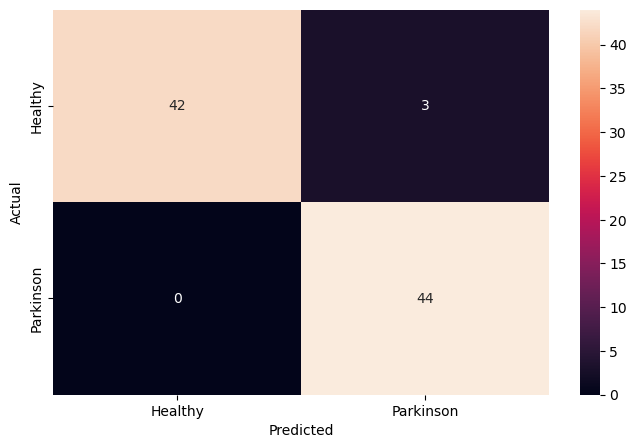

In [21]:
y_pred_kernel = gs_kernel.predict(X_test)

plot_cm(y_pred=y_pred_kernel, y_true=y_test)

Let's try our svm model on the testing set and plot the results on the 2 first principal components.

number of support vectors: 84


/var/folders/zn/_2h7w2j547357vpm3_5pxrsr0000gn/T/ipykernel_38071/3732763266.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


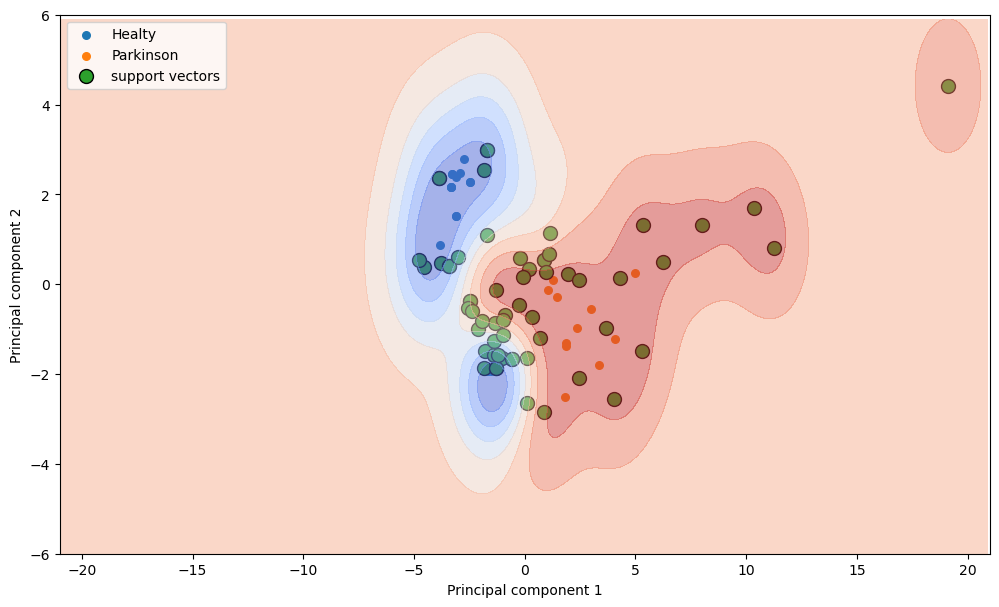

In [22]:
svm_kernel = SVC(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"])

svm_kernel.fit(X_test, y_test)
print(f"number of support vectors: {len(svm_kernel.support_vectors_)}")

clf_kernel = svm_kernel.fit(X_test_pca, y_test)

plot_decision_regions(X_test_pca, y_test, svm_kernel.support_vectors_, clf_kernel, cmap="coolwarm")

In [31]:
SVC(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"], verbose=True).fit(X_train, y_train).score(X_train, y_train)

[LibSVM]*
optimization finished, #iter = 201
obj = -31.265882, rho = 0.569095
nSV = 169, nBSV = 68
Total nSV = 169


0.9902439024390244

In [30]:
# just to get the min value of the objective function
SVC(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"], verbose=True).fit(X_test, y_test)

[LibSVM]*
optimization finished, #iter = 201
obj = -31.265882, rho = 0.569095
nSV = 169, nBSV = 68
Total nSV = 169


SVC(C=0.44897959183673475, gamma=0.35, verbose=True)

converged at loop 49
----- CUSTOM SVM with Kernel Trick -----
score on testing set: 0.9887640449438202


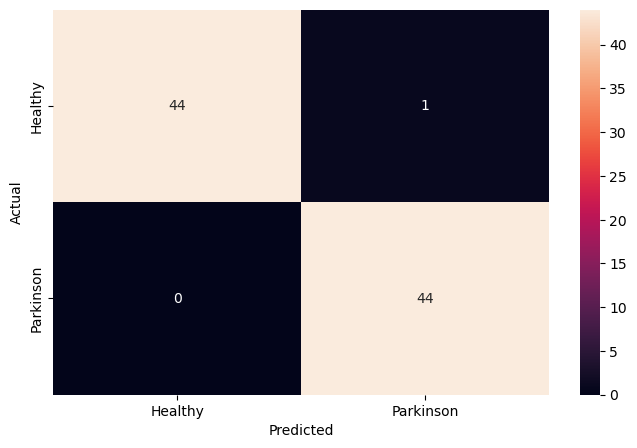

In [24]:
custom_svm = SVM_SGA(kernel="rbf", C=gs_kernel.best_params_["C"], gamma=gs_kernel.best_params_["gamma"])
custom_svm.fit(X_train, y_train)
y_pred_custom = custom_svm.predict(X_test)

print("----- CUSTOM SVM with Kernel Trick -----")
print(f"score on testing set: {custom_svm.score(X_test, y_test)}")

plot_cm(y_pred=y_pred_custom, y_true=y_test)

### Number of support vectors (RBF kernel)

In [60]:
svm_kernel.fit(X_test, y_test)
svm_kernel_sv = svm_kernel.support_vectors_
svm_kernel_sv.sort(axis=0)

print("RBF Kernel - Library")
print(f"number of support vectors: {len(svm_kernel_sv)}")

RBF Kernel - Library
number of support vectors: 61


In [62]:
custom_svm.fit(X_test, y_test)
custom_svm_sv = custom_svm.support_vectors
custom_svm_sv.sort(axis=0)


print("RBF Kernel - Custom implementation")
print(f"number of support vectors: {len(custom_svm_sv)}")

converged at loop 99
RBF Kernel - Custom implementation
number of support vectors: 58
